## Evaluation One-Class Sampling on Synthetic Data

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="ticks", font_scale=1.25)

In [3]:
from eval_utils import *

In [4]:
OUR_METHOD_NAME = 'RAPID'

In [5]:
pd.options.display.max_columns = None
pd.options.display.precision = 4
pd.options.display.max_rows = 100
nan = np.nan
PLOT_PATH = '../plots'

In [6]:
df = load_results(['synthetic'])

In [7]:
def process_syn_data_stats(x):
    values = list(map(int, re.findall(r'\d+', x)))
    return {'n_in': values[0], 'n_out': values[1], 'n_clusters': values[3], 'syn_seed': values[4]}
syn_new_cols = pd.DataFrame(df.data_file.apply(process_syn_data_stats).tolist(), index=df.index)
df = df.merge(syn_new_cols, left_index=True, right_index=True)
df['scenario'] = df['data_set_name']
df['sample_ratio'] = df['sample_size'] / df['n_in']

Inspect exit codes

In [8]:
df.groupby(['sst', 'exit_code']).count()[['ss']]

ss
sst         exit_code               
PP_BPS      success               85
PP_DAEDS    success               85
PP_DBSRSVDD EmptySampleException  26
            success               59
PP_FBPE     success               85
PP_HSR      success               85
PP_IESRSVDD success               85
PP_KFNCBD   success               85
PP_NDPSR    EmptySampleException   7
            success               78
PP_RAPID    success               85

In [9]:
d = df.groupby(['sst', 'data_set_name']).count()[['ss']].reset_index()
d = d.pivot(index='data_set_name', columns='sst', values='ss')
d

sst,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,PP_RAPID
data_set_name,,,,,,,,,
clusters,25,25,25,25,25,25,25,25,25
dims,25,25,25,25,25,25,25,25,25
sizes,35,35,35,35,35,35,35,35,35


In [10]:
df['ss_threshold_strat'] = ['None' if x is np.nan else x for x in df['ss_threshold_strat']]

In [11]:
df_success = df.query('exit_code == "success"').sort_values('ss')

Outlier ratio

In [12]:
d = df_success.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']].round(4)
d.loc['MEAN'] = d.mean()
d.loc['MEAN']

n_observations    2918.8453
outlier_ratio        0.4649
Name: MEAN, dtype: float64

## Our method RAPID against competitors

In [13]:
target_threshold_strat = 'GroundT()'

competitors_sst = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = ['PP_RAPID']

target_df = df_success
target_svdd_result = 'svdd_reinit_MMC_C1_mcc'

In [14]:
d_plot = []
for s in competitors_sst + our_methods:
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby(['scenario', 'sst', 'ss', 'data_file']).mean()[[target_svdd_result, 'sample_size', 'sample_ratio', target_svdd_result.replace('mcc', 'num_support_vectors'), target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]]
    x.columns = ['svdd', 'size', 'ratio', 'SVs', 't_train', 't_samp']
    d_plot.append(x)

d_plot = pd.concat(d_plot).reset_index().set_index(['scenario', 'data_file'])
d_plot['sst'] = d_plot['sst'].apply(lambda x: x.split('_')[1])
stats = target_df.groupby(['scenario', 'data_file']).mean()[['outlier_ratio', 'n_in', 'n_dims', 'n_clusters']]
d_plot = d_plot.merge(stats[['n_in']], how='left', left_index=True, right_index=True)
d_plot = d_plot.merge(stats[['n_dims']], how='left', left_index=True, right_index=True)
d_plot = d_plot.merge(stats[['n_clusters']], how='left', left_index=True, right_index=True).reset_index()
d_plot = d_plot[['scenario', 'n_in', 'n_dims', 'n_clusters', 'sst', 'ss', 'svdd', 'size', 'ratio', 'SVs', 't_train', 't_samp']]
d_plot[['n_in', 'n_dims', 'n_clusters']] = d_plot[['n_in', 'n_dims', 'n_clusters']].astype(int)
d_plot.head()

,scenario,n_in,n_dims,n_clusters,sst,ss,svdd,size,ratio,SVs,t_train,t_samp
0,clusters,1000,50,10,BPS,PP_BPS(0.005),1.0000,1000,1.000,25.0,5.7276,1.1357
1,clusters,1000,50,10,DAEDS,"PP_DAEDS(30, 0.1, 0.3)",0.9675,192,0.192,11.0,0.1654,0.8577
2,clusters,1000,50,10,FBPE,PP_FBPE(360),0.8801,31,0.031,13.0,0.0227,0.0394
3,clusters,1000,50,10,HSR,"PP_HSR(20, 0.01)",0.5627,14,0.014,9.0,0.0207,0.0161
4,clusters,1000,50,10,IESRSVDD,PP_IESRSVDD(0.5),0.9990,417,0.417,19.0,0.7867,0.7044


In [15]:
d_sizes, d_dims, d_clusters = d_plot.query('scenario == "sizes"'), d_plot.query('scenario == "dims"'), d_plot.query('scenario == "clusters"')

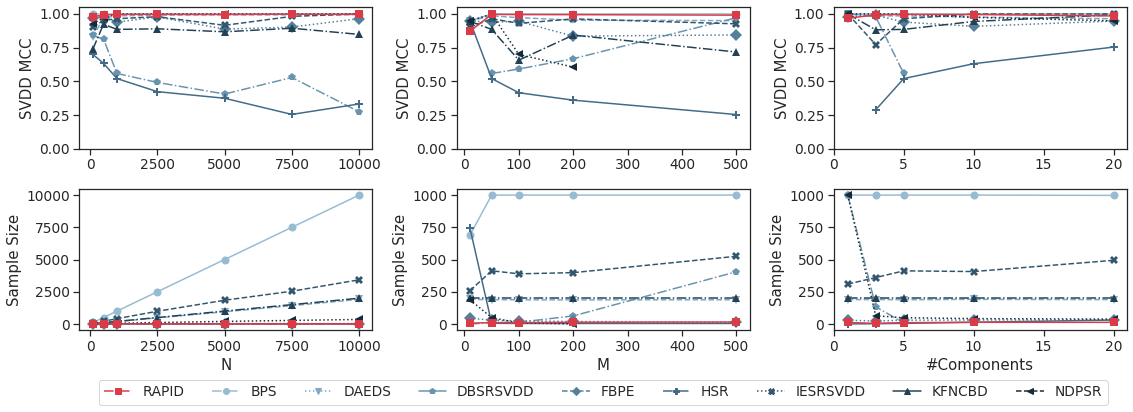

In [16]:
hue_order = [x.split('_')[1] for x in competitors_sst + our_methods]
f_dashes = ('-', '--', '-.', ':')
filled_markers = ('o', 'v', '^', '<', '>', 's', 'X', '*', 'D', 'P')
markers = {}
filled_markers = ('o', 'v', 'p', 'D', 'P', 'X', '^', '<', '*', '>')
for i, s in enumerate(competitors_sst):
    markers[s.split('_')[1]] = filled_markers[i]
markers['RAPID'] = 's'
colorpalette = sns.cubehelix_palette(8, start=2.666, rot=-.01, light=0.7) + [(0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]
kwargs = {'hue': 'sst', 'hue_order': hue_order, 'err_style': None, 'legend': None,
          'style': 'sst', 'dashes': False, 'markers': markers, 'palette': colorpalette, 'markeredgewidth': 0, 'markersize': 8}
kwargs_leg = {**kwargs, 'legend': 'full'}

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 6))
sns.lineplot(data=d_sizes, x='n_in', y='svdd', ax=ax1, **kwargs)
sns.lineplot(data=d_sizes, x='n_in', y='size', ax=ax4, **kwargs)
sns.lineplot(data=d_dims, x='n_dims', y='svdd', ax=ax2, **kwargs)
sns.lineplot(data=d_dims, x='n_dims', y='size', ax=ax5, **kwargs_leg)
sns.lineplot(data=d_clusters, x='n_clusters', y='svdd', ax=ax3, **kwargs)
sns.lineplot(data=d_clusters, x='n_clusters', y='size', ax=ax6, **kwargs)

for ax in fig.axes:
    for i, l in enumerate(ax.lines):
        l.set_linestyle(f_dashes[i % len(f_dashes)])
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('')
    ax.set_ylabel('SVDD MCC')
    ax.set_ylim(0, 1.05)
for ax in [ax4, ax5, ax6]:
    ax.set_ylabel('Sample Size')
ax4.set_xlabel('N')
ax5.set_xlabel('M')
ax6.set_xlabel('#Components')
ax3.set_xlim(0, max(ax3.get_xlim()))
ax6.set_xlim(0, max(ax6.get_xlim()))
ax5.legend()
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles=[handles[-1]] + handles[1:-1], labels=[OUR_METHOD_NAME] + labels[1:-1], loc='upper center', bbox_to_anchor=(0.5, -0.30),
           ncol=10)
fig.tight_layout(w_pad=-23.5)
ax1.set_xticks([0, 2500, 5000, 7500, 10000])
ax4.set_xticks([0, 2500, 5000, 7500, 10000])
ax3.set_xticks([0, 5, 10, 15, 20])
ax6.set_xticks([0, 5, 10, 15, 20]);

In [17]:
fig.savefig(os.path.join(PLOT_PATH, 'eval_synthetic.pdf'))
fig.savefig(os.path.join(PLOT_PATH, 'eval_synthetic.png'), dpi=300)

Sampling time

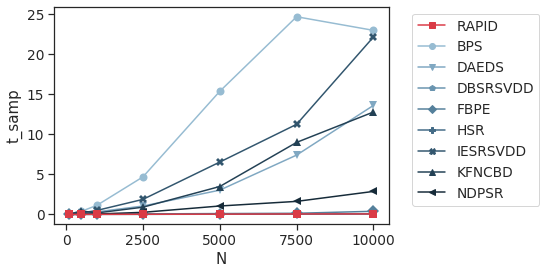

In [18]:
f = sns.lineplot(data=d_sizes, x='n_in', y='t_samp', **kwargs_leg)
f.axes.legend()
handles, labels = f.axes.get_legend_handles_labels()
plt.legend(handles=[handles[-1]] + handles[1:-1], labels=[OUR_METHOD_NAME] + labels[1:-1], bbox_to_anchor=(1.05, 1), loc=0, title=None)
plt.xticks([0, 2500, 5000, 7500, 10000])
plt.xlabel('N')
plt.ylabel('t_samp');